In [1]:
# Author: Samantha Tetef
# Created: 1.29.20
# Title: XESML

# This notebook analyzes hundreds of sulfur compound VtC-XES spectra using various machine learning techniques

In [2]:
import warnings
warnings.filterwarnings("ignore")

from utils import *

## to reload utils:
# from importlib import reload
# import utils as utils
# utils = reload(utils)
# from utils import *

from random import randint

import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.activations import*
from keras.models import load_model

from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.manifold import TSNE

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
%%javascript
 IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
 }

<IPython.core.display.Javascript object>

## Intro figures

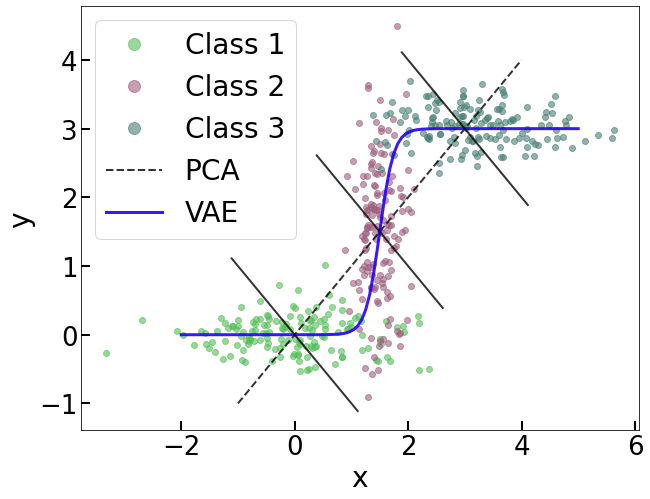

In [4]:
def sigma(x):
    return (1/(1 + np.exp(-8*(x-1.5))))*3

n = 150
np.random.seed(42)

c1 = np.random.multivariate_normal([0.,0.], [[1.05,0.0],[0.0,0.07]], size=(n))
c2 = np.random.multivariate_normal([1.5,1.5], [[.07,0.],[0.,.95]], size=(n))
eps = np.random.normal(0, 0.3, size=(n))
x2 = np.linspace(0., 3, n)
c3 = np.random.multivariate_normal([3.,3.], [[1.05,0.0],[0.0,0.07]], size=(n))

fig, ax = plt.subplots(figsize=(10,7.8))

# plotting data
plt.plot(c1[:,0], c1[:,1], '.', c=COLORS[3], label='Class 1', alpha=0.6, markersize=12)
plt.plot(c2[:,0], c2[:,1], '.', c='#9F5F80', label='Class 2', alpha=0.6, markersize=12)
plt.plot(c3[:,0], c3[:,1], '.', c='#488077', label='Class 3', alpha=0.6, markersize=12)

plt.plot(np.linspace(-1,4,10), np.linspace(-1,4,10), '--', c='k', linewidth = 2, alpha=0.8, label='PCA')

a, b, c = np.linspace(-2,2,10), np.linspace(-0.5,3.5,10), np.linspace(1,5,10)

# VAE
color1 = '#000080'
color1 = '#2200ff' 
lw = 3
x = np.linspace(-2,5,100)
plt.plot(x, sigma(x), '-', c=color1, linewidth=lw, alpha=0.9, label='VAE')

# PCA
color2 = 'k'
alp = 0.8
plt.plot(a[2:8], -a[2:8], '-', c=color2, linewidth=2, alpha=alp)
plt.plot(b[2:8], -b[2:8]+3, '-', c=color2, linewidth=2, alpha=alp)
plt.plot(c[2:8], -c[2:8]+6, '-', c=color2, linewidth=2, alpha=alp)

plt.xlabel('x', fontsize=28)
plt.ylabel('y', fontsize=28)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
ax.tick_params(direction='in', width=2, length=9)
plt.legend(fontsize=28, markerscale=2)

plt.show()

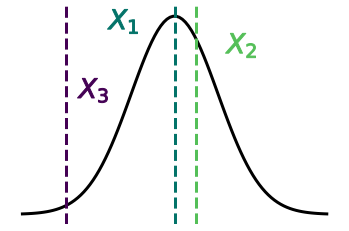

In [5]:
x = np.linspace(-3.5,3.5,100)
y = scipy.stats.norm.pdf(x)

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(x, y, 'k-', linewidth=3)
plt.axvline(x=0, color=COLORS[2], linestyle='--', linewidth=3)
plt.axvline(x=0.5, color=COLORS[3], linestyle='--', linewidth=3)
plt.axvline(x=-2.5, color=COLORS[0], linestyle='--', linewidth=3)
plt.plot(-1.2, 0.39, marker='$X_1$', markersize=30, color=COLORS[2])
plt.plot(1.5, 0.34, marker='$X_2$', markersize=30, color=COLORS[3])
plt.plot(-1.9, 0.25, marker='$X_3$', markersize=30, color=COLORS[0])
# plt.plot(2.3, 0.25, marker='s', markersize=20, color=COLORS[3])
# plt.plot(-2, 0.33, marker='*', markersize=30, color=COLORS[2])

plt.axis('off')
    
plt.show()

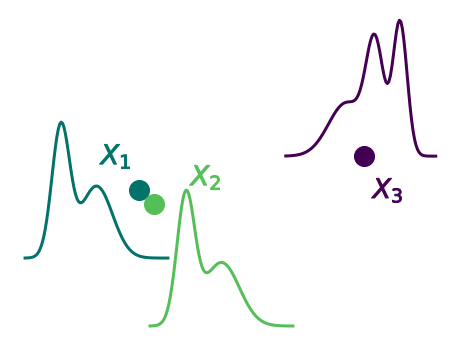

In [6]:
x1 = np.linspace(-2,2,100)
y1 = scipy.stats.norm.pdf(x1, loc=0, scale=0.45)
y1 += scipy.stats.norm.pdf(x1, loc=-1., scale=0.25)

x2 = np.linspace(-2,2,100)
y2 = scipy.stats.norm.pdf(x2, loc=0., scale=0.5)
y2 += scipy.stats.norm.pdf(x2, loc=-1., scale=0.25)

x3 = np.linspace(-0.2,4.,100)
y3 = scipy.stats.norm.pdf(x3, loc=3., scale=0.2)
y3 += scipy.stats.norm.pdf(x3, loc=2.3, scale=0.25)
y3 += scipy.stats.norm.pdf(x3, loc=1.5, scale=0.5)

y1 = y1/np.max(y1)
y2 = y2/np.max(y2)
y3 = y3/np.max(y3)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x1-3, 2*y1 + 1, '-', linewidth=3, color=COLORS[2])
ax.plot(x2+0.5, 2*y2, '-', linewidth=3, color=COLORS[3])
ax.plot(x3+2.5, 2*y3 + 2.5, '-', linewidth=3, color=COLORS[0])

plt.plot(-2.5, 2.5, marker='$X_1$', markersize=30, color=COLORS[2])
plt.plot(0., 2.2, marker='$X_2$', markersize=30, color=COLORS[3])
plt.plot(5.1, 2, marker='$X_3$', markersize=30, color=COLORS[0])

plt.plot(-1.8, 2, marker='o', markersize=20, color=COLORS[2])
plt.plot(-1.4, 1.8, marker='o', markersize=20, color=COLORS[3])
plt.plot(4.5, 2.5, marker='o', markersize=20, color=COLORS[0])

plt.axis('off')

plt.xlim(-5.5,7)
plt.ylim(-0.1,4.7)
    
plt.show()

In [7]:
# print color scheme
for c in COLORS:
    print(to_hex(c))

#440154
#3b66b3
#037369
#54bf58
#e4ce0c


# Reading in spectra

Reading in compound names from lists (text files)

In [8]:
# setting up directory
ROOTDIR = os.getcwd()
TYPEdir = "Categories/"

### Creating dictionary list of compound categories

Spectrum must have been preprocessed using the SpectraFromDat python script

In [9]:
Data = get_XES(Types, TYPEdir)
N = len(Data)
NAMES = get_Property(Data, 'name')

PROPERTIES = ['oxy', 'Type', 'category']
Labels = []
for PROPERTY in PROPERTIES:
    Labels.append(get_Property(Data, PROPERTY))

# XES

Separating energy, which should be the same for all XES spectra, and the spectra itself

In [10]:
XES = np.array(get_Property(Data, 'XES'))
XESenergy = XES[0,0,:]

X = np.array(get_Property(Data, 'XES'))[:,1,:]

SCALING_FACTOR = np.max(X)
# peak normalizing spectra over entire ensemble!
X = X / SCALING_FACTOR

# TEST

In [11]:
test_list = get_text_in_file('Categories/TEST.txt').split('\n')
# test_list = ['2-Fluorocyclohexane-1-thiol']

TESTData = get_TEST_Data(test_list, directory='XES')
TEST_NAMES = get_Property(TESTData, 'Name')

TEST_XES_tuple = np.array(get_Property(TESTData, 'Spectra'))
TEST_XES = TEST_XES_tuple[:,1,:]

TEST_XES = TEST_XES/SCALING_FACTOR

print(len(TEST_NAMES))

52


In [12]:
def esnip(trans, emin, spectrum):
    x,y = trans
    x = x - 18.6
    for i, e in enumerate(x):
        if e >= emin:
            break
    x = x[i:]
    y = y[i:]
    
    if x[-1] < 0:
        return x[:-1], y[:-1]
    
    y = y/np.max(y)
    
    return x, y*np.max(spectrum)

In [13]:
# name='2-Fluorocyclohexane-1-thiol'
# index = TEST_NAMES.index(name)

# x = TEST_XES[index]/SCALING_FACTOR
# trans = TESTData[index]['Transitions']

# trans = esnip(trans, 2400, x)
# trans_cut = [trans[0][1:], trans[1][1:]]
# plot_spectrum_and_trans(trans_cut, [XESenergy, x], f'{name}', figsize=(8,6), label='XES', ylab=False, emp=[-1])

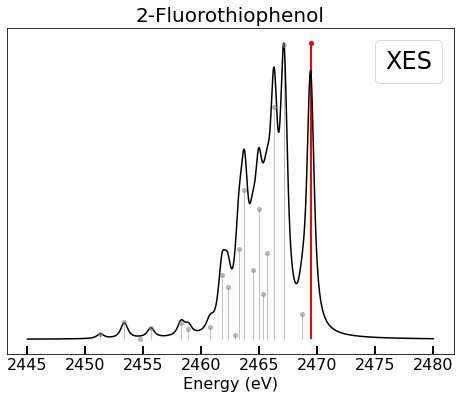

In [14]:
name= '2-Fluorothiophenol'
index = NAMES.index(name)

x = get_Spectrum(Data, name)[1]/SCALING_FACTOR
trans = Data[index]['Transitions']

trans = esnip(trans, 2400, x)
trans_cut = [trans[0][1:], trans[1][1:]]
plot_spectrum_and_trans(trans_cut, [XESenergy, x], f'{name}', figsize=(8,6), label='XES', ylab=False, emp=[-1])

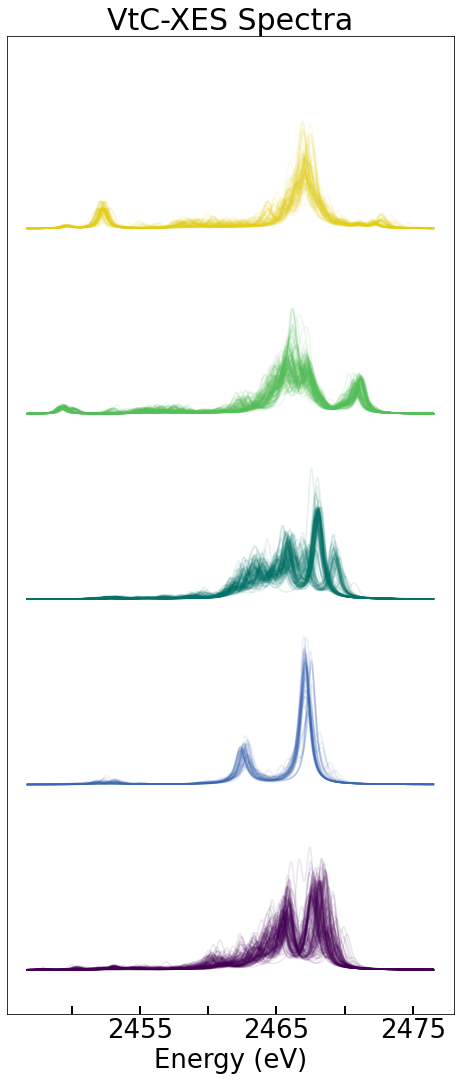

In [15]:
Spagetti_plot(Data, XESenergy, SCALING_FACTOR, mode='VtC-XES')

# Data analysis

### Type Number vs Transition Integral:

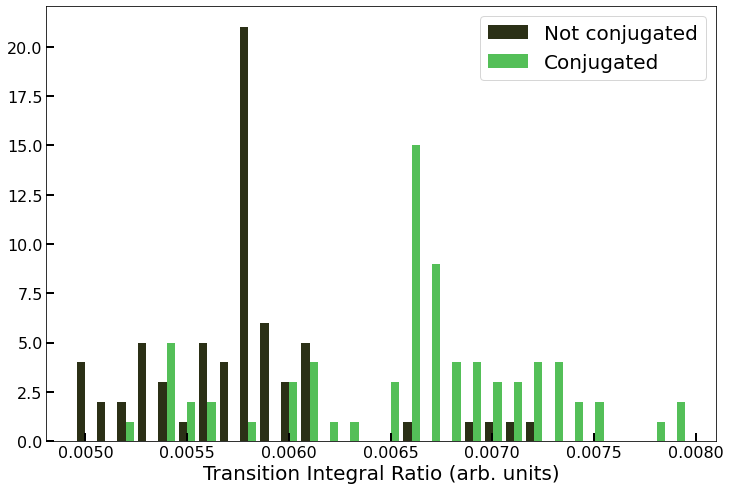

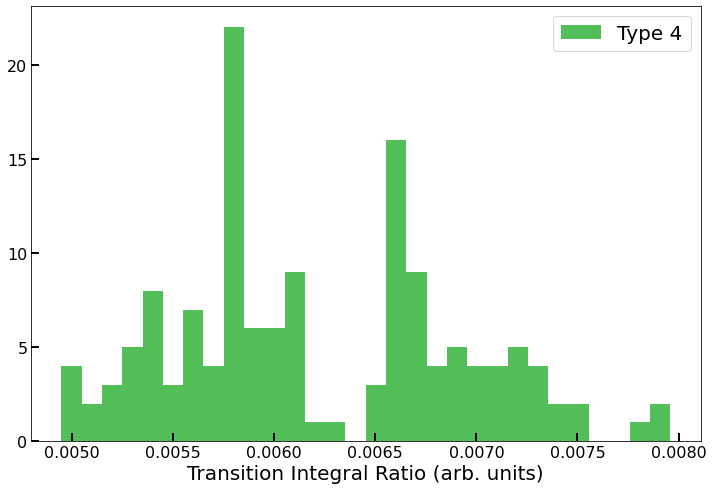

In [16]:
create_transition_v_type_hist(Data, chosen_type=4, show_conj=True) # showing conjugated
create_transition_v_type_hist(Data, chosen_type=4) # everything

=========================================================================================================================

# Artificial Neural Network Section

### Network hyperparameters

In [17]:
# hidden layer dimensions
intermediate_dim_1 = 512

batch_size = 50
epochs = 120

train_size = 700

### Generating Labels

In [18]:
PROPERTY = 'Type'
# PROPERTY = 'oxy'
# PROPERTY = 'category'

In [19]:
X = X.copy()
Y = get_Property(Data, PROPERTY) # labels are one hot encoded

## Data pre-processing and shuffling

In [20]:
# # random shuffle of data
index_shuffle = np.arange(len(Data))
random.shuffle(index_shuffle)

In [21]:
Xshuffle = []
Yshuffle = []
for index in index_shuffle:
    Xshuffle.append(X[index])
    Yshuffle.append(Y[index])
Xshuffle = np.array(Xshuffle)
Yshuffle = np.array(Yshuffle)

#### Dividing data into training set, validation set, and test set

In [22]:
x_train = Xshuffle[:train_size]
y_train = Yshuffle[:train_size]

x_test = Xshuffle[train_size:]
y_test = Yshuffle[train_size:]

n_y = y_train.shape[1]
n_x = x_train.shape[1]

# Generating new ANN Model

In [23]:
# # creating model
# # input
# Xin = Input(shape=(n_x,), name='spectra_input')
# # model layers
# lay = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
# lay = Dropout(0.05)(lay)
# nn_out = Dense(n_y, activation='softmax', name='classifier')(lay)

# ANN = Model(Xin, nn_out)

# ANN.compile(optimizer='adam', loss='binary_crossentropy')
# ANN.summary()

# ANN.fit(x_train, y_train, 
#          shuffle=True, batch_size=batch_size, epochs=epochs,
#          validation_data=(x_test, y_test))
# ANN.save(f'models/XES_ANN_{PROPERTY}.h5')

# Loading pre-trained model

In [24]:
PROPERTY = 'Type'
# PROPERTY = 'oxy'
# PROPERTY = 'category'
ANN = load_model(f'models/XES_ANN_{PROPERTY}.h5', compile=False)

# Prediction Results

In [25]:
if PROPERTY == 'oxy':
    one_hot_encoded_label = np.zeros((len(TEST_XES), 3))
    for i,o in enumerate(TEST_OXY):
        one_hot_encoded_label[i,o-1] = 1
    true, pred = get_prediction(ANN, TEST_XES, one_hot_encoded_label)
if PROPERTY == 'Type':
    one_hot_encoded_label = np.zeros((len(TEST_XES), 5))
    for i,t in enumerate(TEST_TYPE):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XES, one_hot_encoded_label)
if PROPERTY == 'category':
    one_hot_encoded_label = np.zeros((len(TEST_XES), 10))
    for i,t in enumerate(TEST_CAT):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XES, one_hot_encoded_label)

In [26]:
totalTestAccuracy = sum(1 for i in range(len(pred)) if pred[i] == true[i])/len(pred)
print(f"Total accuracy on test data: {totalTestAccuracy} of {len(pred)} compounds")

Total accuracy on test data: 0.9615384615384616 of 52 compounds


## Confusion Matrix

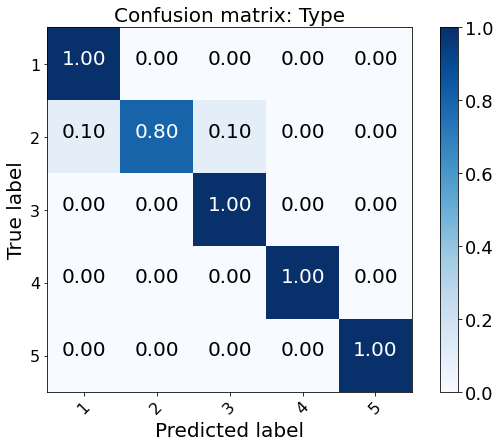

In [27]:
if PROPERTY == 'Type':    
    make_confusion_matrix(true, pred, Types, PROPERTY, cmap=plt.cm.Blues)
if PROPERTY == 'oxy':
    make_confusion_matrix(true, pred, Oxys, PROPERTY, cmap=plt.cm.Blues)
if PROPERTY == 'category':
    make_confusion_matrix(true, pred, Categories, PROPERTY, cmap=plt.cm.Blues)

=========================================================================================================================

# VAE Categorization

### Creating new model

In [28]:
# class Sampling(tf.keras.layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [29]:
# hidden layer dimensions
# intermediate_dim_1 = 512
# intermediate_dim_2 = 128#246
# latent_dim = 2

# epochs = 150

# dropout = 0.1

# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# # encoder
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(Xin)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_2, activation='relu', kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean_val, z_log_var_val = args
#     batch = K.shape(z_mean_val)[0]
#     dim = K.int_shape(z_mean_val)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean_val + K.exp(0.5 * z_log_var_val) * epsilon

# # z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# z = Sampling()([z_mean, z_log_var])

# # encoder
# encoder = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_2, activation='relu', kernel_regularizer='l2')(latent_inputs)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2')(latent_inputs)
# x = Dropout(dropout)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')
 
# # VAE
# Output = decoder(encoder(Xin)[2])
# vae = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae.add_loss(vae_loss)

# vae.compile(optimizer='adam')
# history = vae.fit(x_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, None))

# # vae.save('models/XES_VAE', save_format="tf")
# # encoder.save('models/XES_encoder', save_format="tf")
# # decoder.save('models/XES_decoder', save_format="tf")

# # can only do this when training, not loading
# show_loss(history, 'XES')
# print(history.history['loss'])

### Loading pre-trained model

In [30]:
vae = load_model('models/XES_VAE', compile=False)
encoder = load_model('models/XES_encoder', compile=False)
decoder = load_model('models/XES_decoder', compile=False)
# vae.summary()

In [31]:
Is = [0, 200, 300, 450, 700]
x_decode = np.array([X[i] for i in Is])
decode_names = np.array([NAMES[i] for i in Is])
print(decode_names)

['1,3-Thiazol-4-ylacetic_acid' 'Protionamide' '4-dimethylamino-thiophenol'
 'Dl-Ethionine_sulfoxide' 'Tetrachlorothiophene-sulfone']


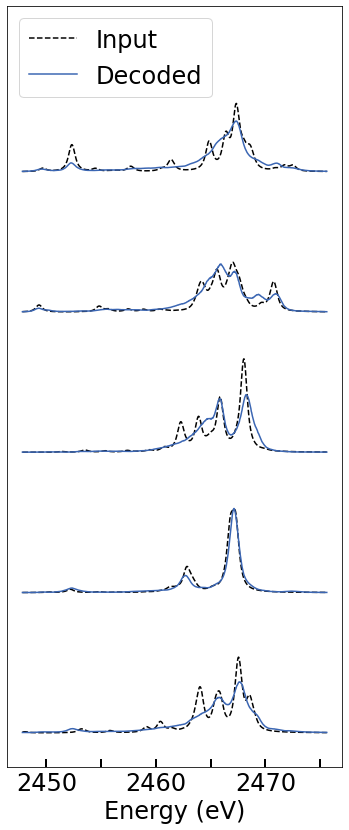

In [32]:
plot_in_v_out(XESenergy, vae, x_decode, decode_names, figsize=(6,14), c=1, x_range=(80,-125), method='XES')

In [33]:
def make_network_plot(Data, encoder):
    X_Types = []
    for t in Types:
        names = get_Property(get_type_eles(Data, t), 'name')
        X_temp = []
        for name in names:
            X_temp.append(get_x(name))
        random.shuffle(X_temp)
        X_Types.append(X_temp)

    percents = np.linspace(0,1,6)

    x_list = []

    sample_size = [20, 10, 20, 20, 20]

    random_start = np.zeros(5)
    for i in Types:
        max_ind = len(X_Types[i-1]) - sample_size[i-1] - 1
        random_start[i-1] = randint(0, max_ind)    
    # print(random_start)

    for i in range(5):
        start_i = int(random_start[i])
        sample_i = sample_size[i]
        for x1 in X_Types[i][start_i : start_i + sample_i]:
            j = i + 1
            if i == j:
                break
            while j < 5:
                start_j = int(random_start[j])
                sample_j = sample_size[j]
                for x2 in X_Types[j][start_j : start_j + sample_j]:
                    x_list.append(np.array([x1*percent + x2*(1-percent) for percent in percents]))
                j += 1

    print(f'Total combinations: {len(x_list)}')       
    network_plot("", x_list, encoder)

In [34]:
def get_x(name):
    x = get_Spectrum(Data, name)[1]
    x = x / SCALING_FACTOR
    return x

In [35]:
def network_plot(title, x_predict_list, encoder):
    
    z_means = []
    for x in x_predict_list:
        z_mean = encoder.predict(x, batch_size=100)[0]
        z_means.append(z_mean)
    
    z_meanX = encoder.predict(X, batch_size=batch_size)[0]
    Y = one_hot_to_num(get_Property(Data, 'oxy'))
    
    fontsize=28
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
        
    Colors = [COLORS[0], COLORS[2], COLORS[4]]
    cmap = ListedColormap(Colors)
    plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
    
    alpha, color, ms = 0.01, 'k', 2
    
    for z_mean in z_means:
        plt.plot(z_mean[:, 0], z_mean[:, 1], '-', c=color, alpha=alpha, markersize=ms)

    loc = [-1.33, 0, 1.33]
    cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
    cbar = plt.colorbar(cax=cbaxes, ticks=Oxys)
    cbar.set_label('Oxidation', fontsize=26)
    cbar.set_ticks(loc)
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticklabels(Oxys)
    
    plt.xticks(fontsize=fontsize+3)
    plt.yticks(fontsize=fontsize+3)
    
    ax.set_xlabel(f"z [0]", fontsize=fontsize+6)
    ax.set_ylabel(f"z [1]", fontsize=fontsize+6)
    ax.tick_params(direction='in', width=2, length=8)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

In [36]:
# make_network_plot(Data, encoder)

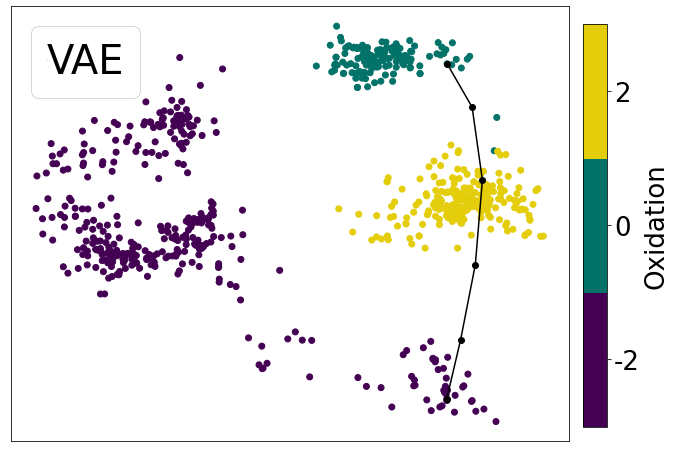

In [37]:
MIN, MAX = 50, 950

name1 = "Goitrin"
x1 = get_x(name1)
name2 = "Thiophene_oxide"
x2 = get_x(name2)
name1, name2 = "goitrin", "thiophene oxide"
percents = np.linspace(0,1,6)
lin_combos = np.array([x1*percent + x2*(1-percent) for percent in percents])

plot(Data, f"Linear Combination Data\n{name1} to {name2} by 20% steps", lin_combos, percents,
     encoder, X, a=1., s=12)

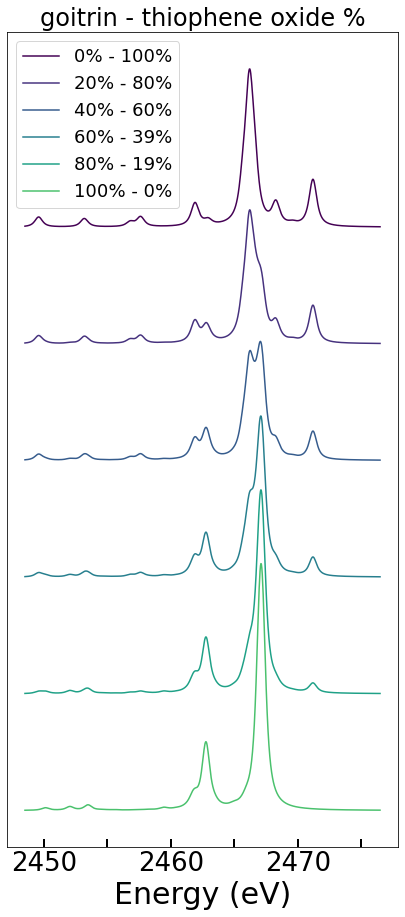

In [38]:
MIN, MAX = 100, 900
names = [f"{int(x*100)}% - {int((1-x)*100)}%" for x in percents]
temp = []
for e in lin_combos:
    temp.append( e[MIN:MAX] ) # 8,16 fontsize 18
stack_plot(XESenergy[MIN:MAX], temp, names, f'goitrin - thiophene oxide %', space=0.4, figsize=(7,15),
          fontsize=26, method='XES', legend_font=18)

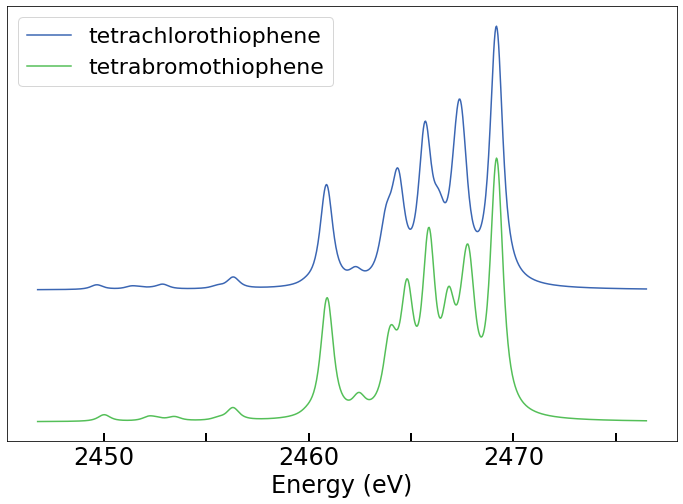

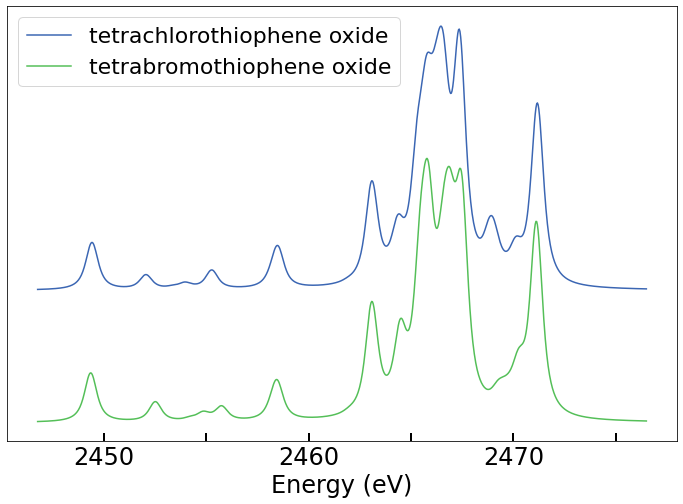

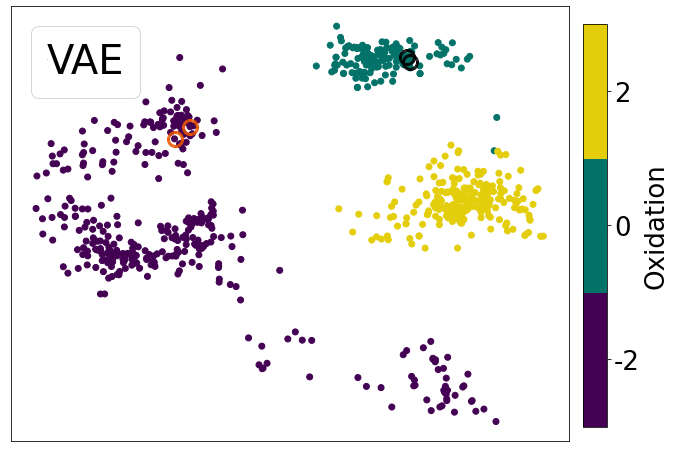

In [39]:
MIN, MAX = 50, 900

name1, name2 = 'Tetrabromothiophene', 'Tetrachlorothiophene'
x1, x2 =  get_x(name1), get_x(name2)
name1, name2 = 'tetrabromothiophene', 'tetrachlorothiophene'
plot_stacked_spectrum(XESenergy[MIN:MAX], x1[MIN:MAX], x2[MIN:MAX], name1, name2,
                      space=0.5, title='', method='XES', loc=2)

name3, name4 = 'Tetrabromothiophene_oxide', 'Tetrachlorothiophene_oxide'
x3, x4 =  get_x(name3), get_x(name4)
name3, name4 = 'tetrabromothiophene oxide', 'tetrachlorothiophene oxide'

plot_stacked_spectrum(XESenergy[MIN:MAX], x3[MIN:MAX], x4[MIN:MAX], name3, name4,
                      title='', space=0.5, method='XES', loc=2)

plot(Data, f"XES", np.array([x1, x2, x3, x4]), [], encoder, X, a=1., s=11)

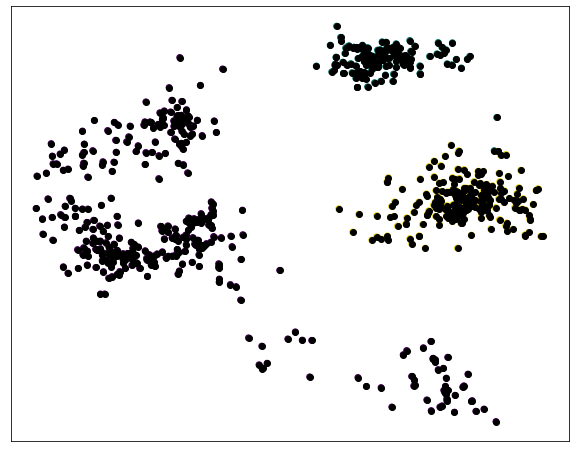

In [40]:
plot(Data, PROPERTIES[0], X, Labels[0], encoder, X, black=True)

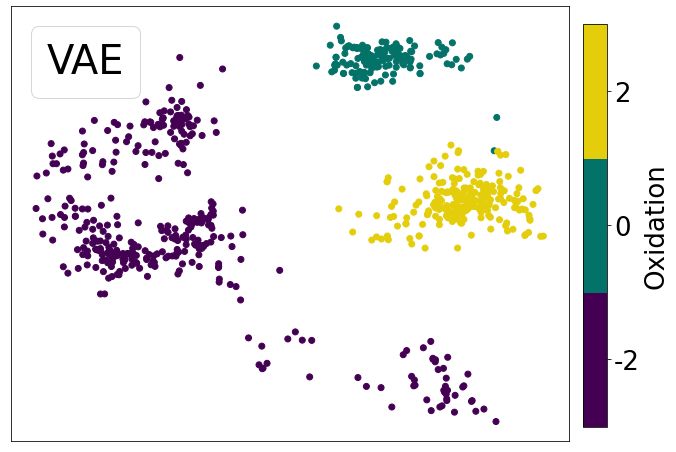

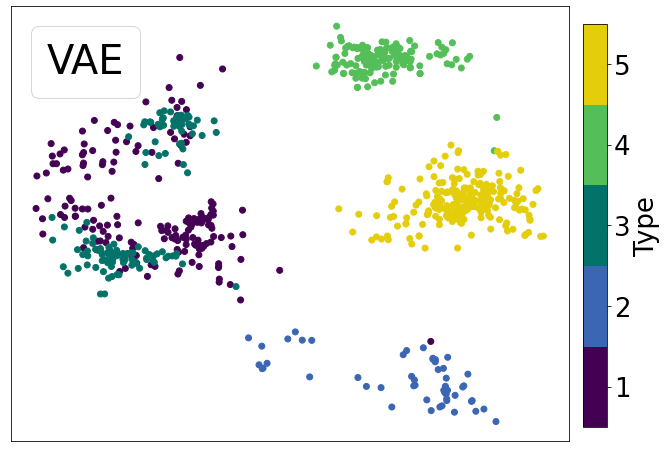

In [41]:
for PROPERTY in PROPERTIES[:2]:
    plot(Data, PROPERTY, X, Labels[PROPERTIES.index(PROPERTY)], encoder, X)

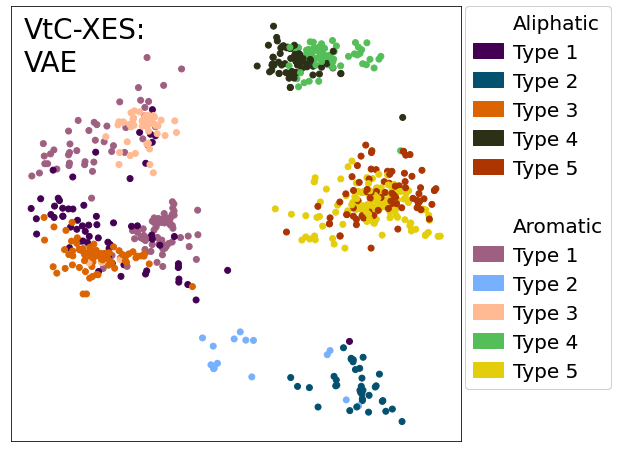

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot(Data, 'category', X, Labels[2], encoder, X)

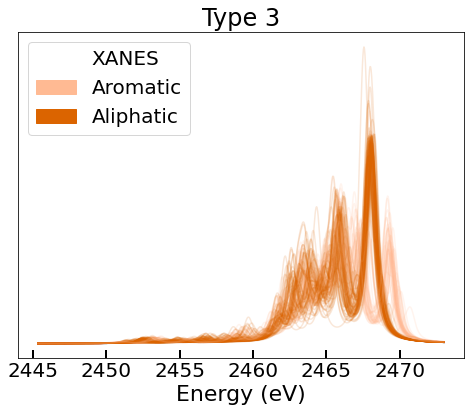

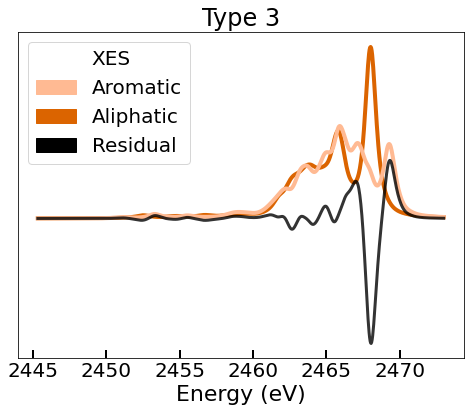

In [43]:
type_spagetti(XESenergy, NAMES, Data, 'XES', X, Type=3, space=0., figsize=(8,6), alpha=0.15) 

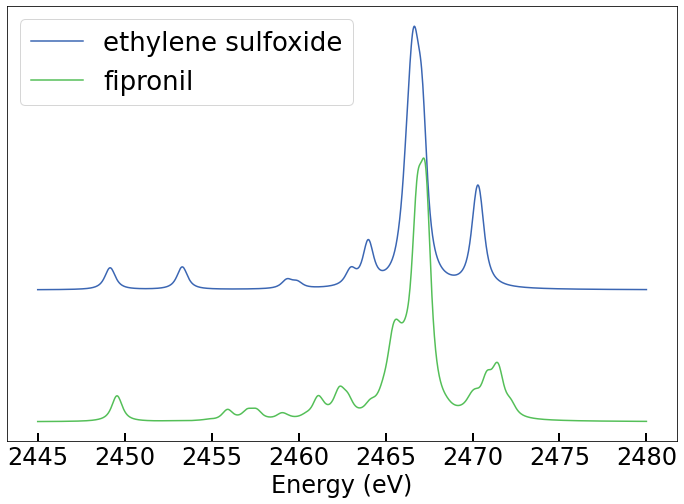

In [44]:
name1, name2 = 'Fipronil', 'Ethylene_sulfoxide'
x1, x2 =  get_x(name1), get_x(name2)
name1, name2 = 'fipronil', 'ethylene sulfoxide'
plot_stacked_spectrum(XESenergy, x1, x2, name1, name2, title=f'', space=0.5)

# K means

In [45]:
def plot_centroids(x_predict, y_predict, codebook):
    
    z_mean = encoder.predict(x_predict, batch_size=batch_size)[0]
    
    fontsize=16
    fig, ax = plt.subplots(figsize=(12, 8))
    if PROPERTY == 'oxy':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=COLORMAP)
        plt.colorbar(ticks=Oxys)
        plt.title("Latent Space vs Sulfur Oxidation", fontsize=fontsize+4)
    elif PROPERTY == 'category':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=COLORMAP)
        plt.colorbar()
        plt.title("Latent Space vs Category", fontsize=fontsize+4)
    else:
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        cbar = plt.colorbar(ticks=Types)
#         plt.title("Latent Space vs Type", fontsize=fontsize+4)
    
    plt.plot(codebook[:, 0], codebook[:, 1], '.', c='r', markersize=20)
    
    cbar.set_label(PROPERTY, fontsize=26)
    cbar.ax.tick_params(labelsize=22)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

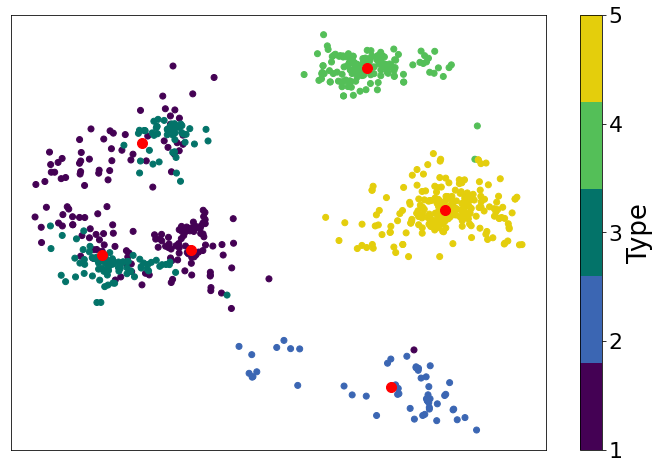

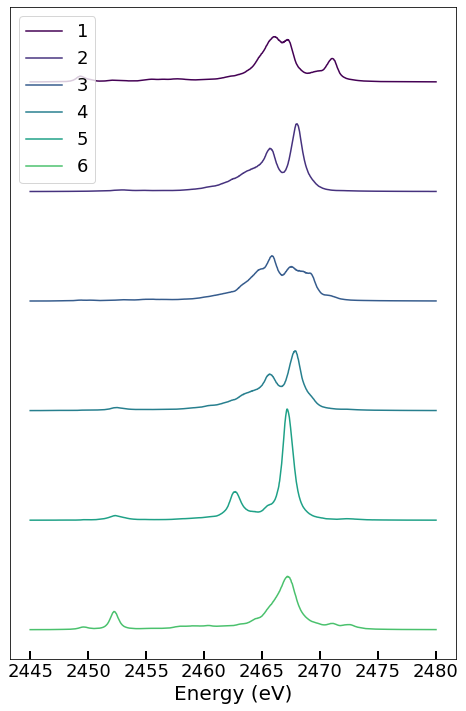

In [46]:
PROPERTY = 'Type'
codebook, distortion = kmeans(encoder.predict(X)[0], 6)
plot_centroids(X, Labels[PROPERTIES.index(PROPERTY)], codebook)
Spectra = decoder.predict(codebook)
stack_plot(XESenergy, Spectra, np.arange(len(codebook))+1, title=f'', space=0.6, figsize=(8,12))

# Principal Component Analysis (PCA)

In [47]:
pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)

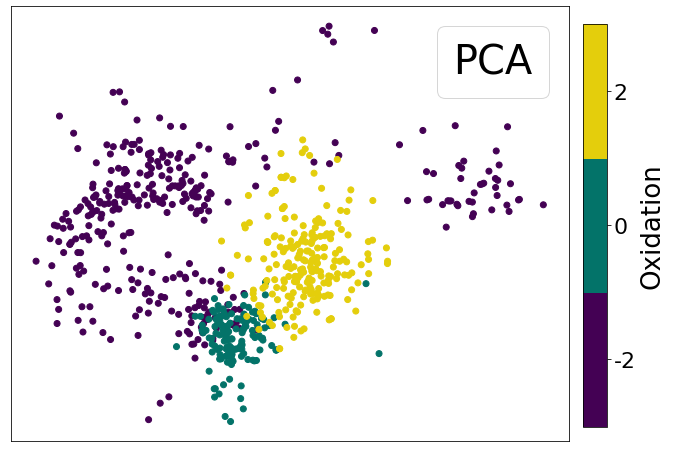

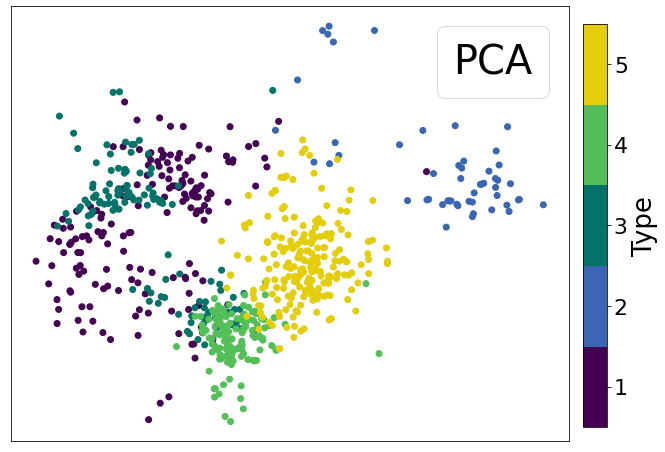

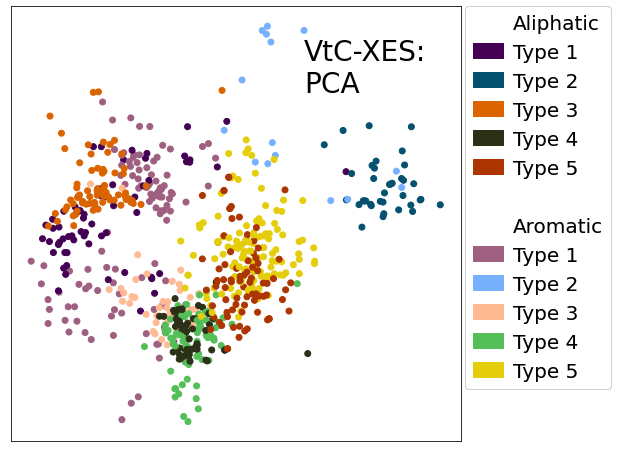

In [48]:
for PROPERTY in PROPERTIES:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plot_dim_red(PROPERTY, X_PCA, Labels[PROPERTIES.index(PROPERTY)],'PCA')

# PCA without specifying dimension

In [49]:
def make_scree(evals, n):

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(n)+1
    N = evals.shape[0]
    colors = COLORMAP(np.arange(N)/N)

    avg = np.zeros(n)
    for i in range(N):
        y = evals[i]
        y = y/np.sum(y)
        avg += y
    
    avg = avg/float(N)
    ax.plot(x, avg, markersize=1, color='k', label='Average')

    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Number of Parameters', fontsize=20)
    plt.ylabel(f'Contribution', fontsize=16)

    plt.show()
    
    return avg

In [50]:
pca = PCA()
pca.fit(X)
X_PCA = pca.transform(X)

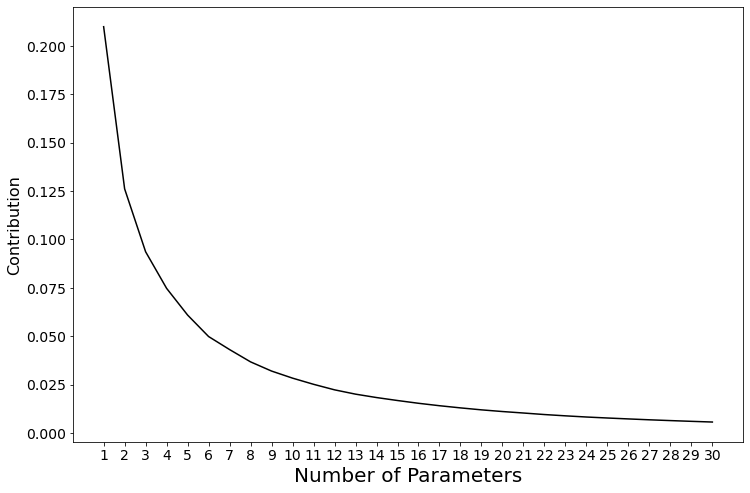

In [51]:
n = 30
evals = np.sort(np.abs(X_PCA), axis=1)
evals = np.flip(evals, axis=1)[:,:n]
xes_pc = make_scree(evals, n)

In [52]:
temp = []
for i in range(n):
    temp.append(f'{xes_pc[i]:.7f}')
temp = np.array(temp)
temp

array(['0.2099057', '0.1261262', '0.0936162', '0.0747139', '0.0609194',
       '0.0498248', '0.0430906', '0.0367303', '0.0319890', '0.0283283',
       '0.0251460', '0.0222887', '0.0200581', '0.0183026', '0.0167693',
       '0.0153394', '0.0140804', '0.0129600', '0.0119433', '0.0110746',
       '0.0103112', '0.0095227', '0.0088531', '0.0082462', '0.0077337',
       '0.0072569', '0.0068053', '0.0063984', '0.0060134', '0.0056523'],
      dtype='<U9')

# PCA analysis

1,3-Thiazol-4-ylacetic_acid


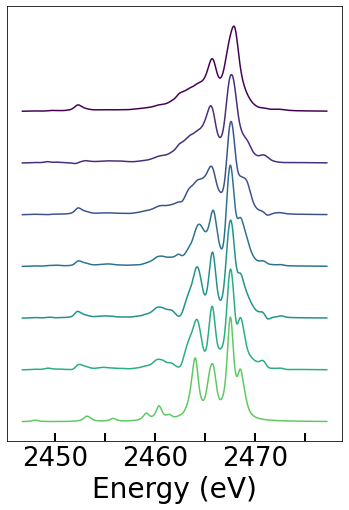

1,3-thiazolidin-2-one-sulfone


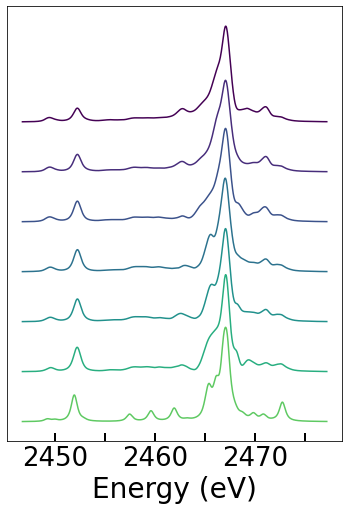

In [53]:
for i in [0, 498]:
    Recon = []
    Names = []

    s, e = 50, -80

    for nc in [2,4,6,8,10,12]:
        pca = PCA(n_components=nc)
        pca.fit(X)
        X_PCA = pca.transform(X)
        recon = pca.inverse_transform(X_PCA)
        Recon.append(recon[i].copy()[s:e])
        Names.append(f"{nc} PCs")

    x = X[i]
    name = Data[i]['name']
    print(name)

    Recon.append(x[s:e])
    Names.append('Target')
    stack_plot(XESenergy[s:e], Recon, Names, '', space=0.2, figsize=(6,8),
               fontsize=24, leg=0, ncol=1, method='XES')

# Other dimensionality reduction

In [54]:
warnings.filterwarnings("ignore")

fastICA = FastICA(n_components=2)
fastICA = fastICA.fit(X)
X_FastICA = fastICA.fit_transform(X)
TEST_X_FastICA = fastICA.transform(TEST_XES)

fa = FactorAnalysis(n_components=2)
fa = fa.fit(X)
X_FA = fa.transform(X)
TEST_X_FA = fa.transform(TEST_XES)

nmf = NMF(n_components=2)
nmf = nmf.fit(X)
X_NMF = nmf.transform(X)
TEST_X_NMF = nmf.transform(TEST_XES)

pca = PCA(n_components=2)
pca = pca.fit(X)
X_PCA = pca.transform(X)
TEST_X_PCA = pca.transform(TEST_XES)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XES, batch_size=5)[0]

tsne = TSNE(n_components=2, perplexity=18, random_state=30)
X_TSNE = tsne.fit_transform(X)

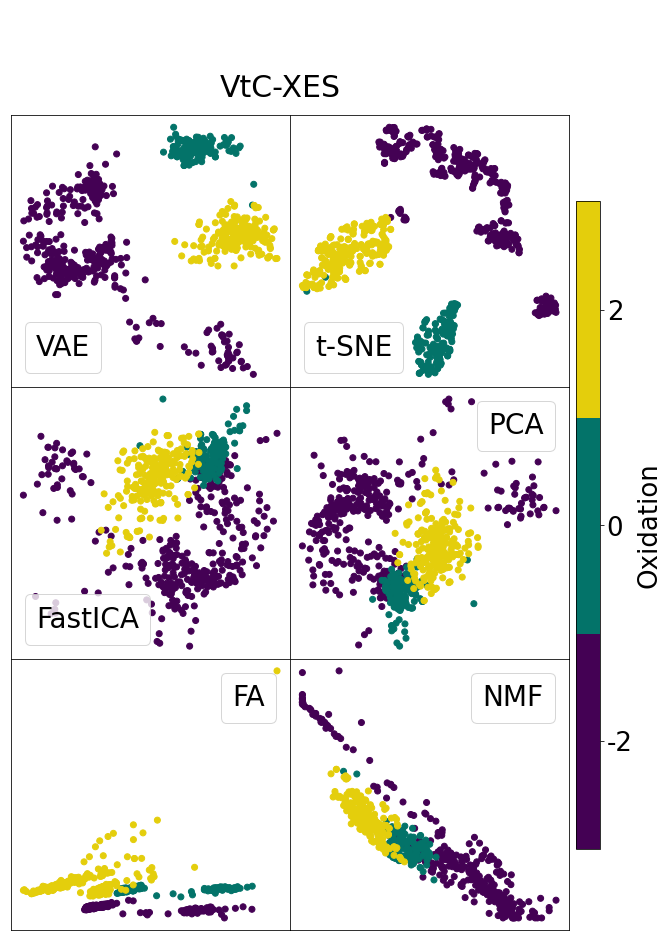

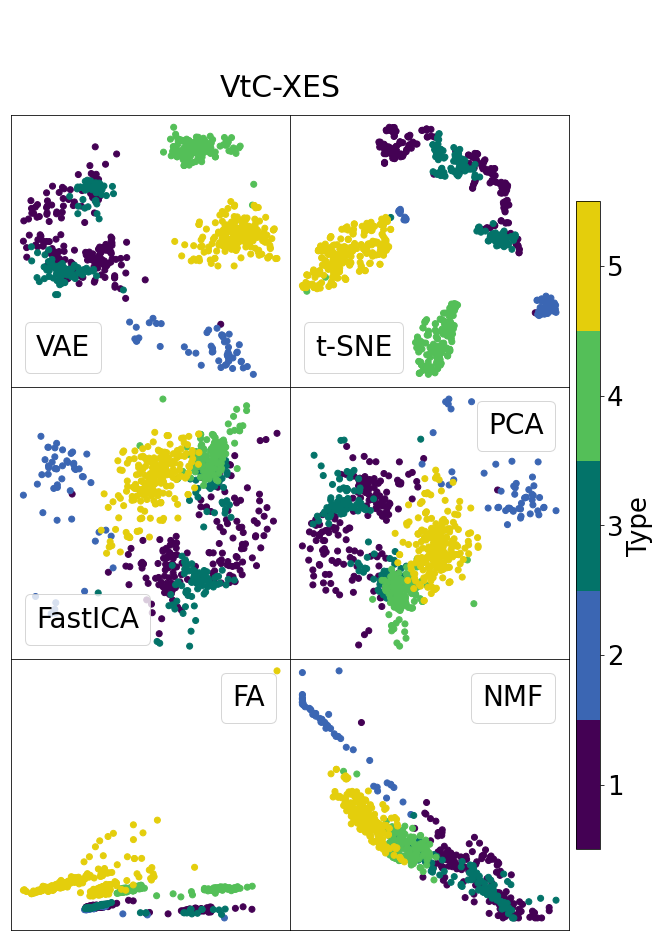

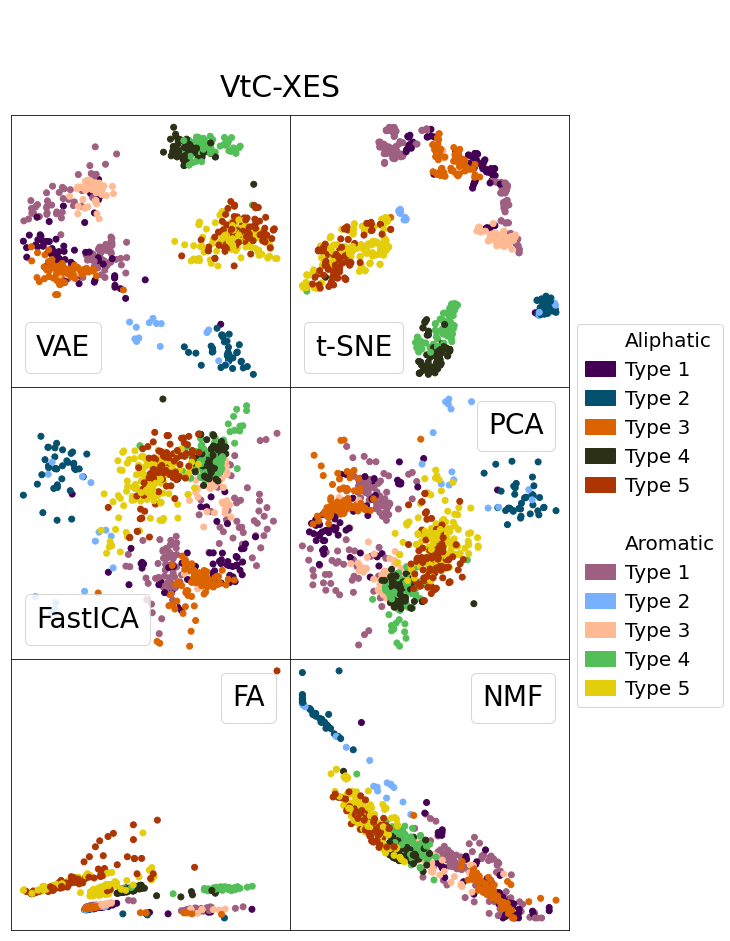

In [55]:
plot_dim_red_stack('oxy', [z_mean, X_TSNE, X_FastICA, X_PCA, X_FA, X_NMF],
                   Labels[0], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'])

plot_dim_red_stack('Type', [z_mean, X_TSNE, X_FastICA, X_PCA, X_FA, X_NMF],
                   Labels[1], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'])

plot_dim_red_stack('category', [z_mean, X_TSNE, X_FastICA, X_PCA, X_FA, X_NMF],
                   Labels[2], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'])

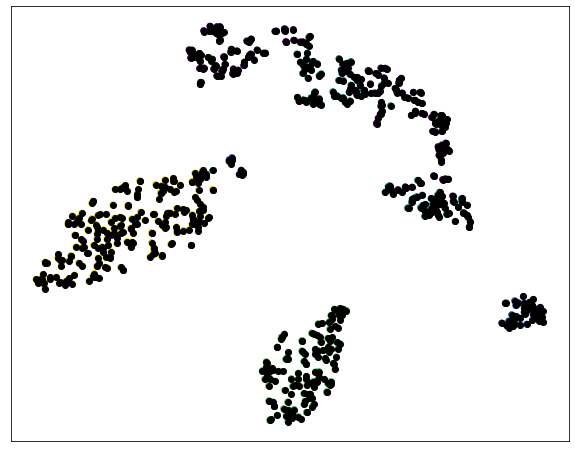

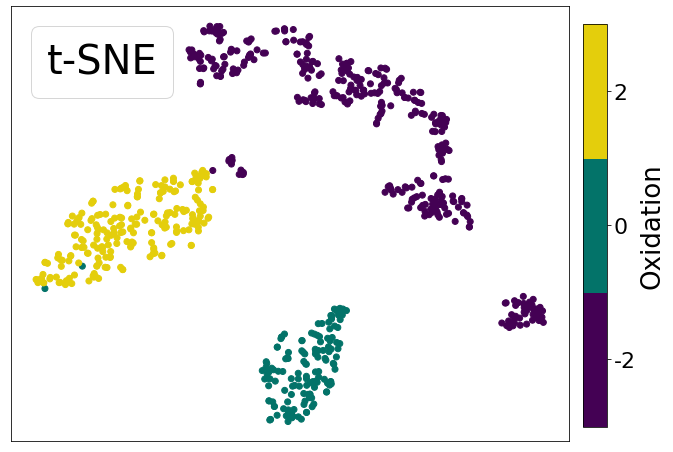

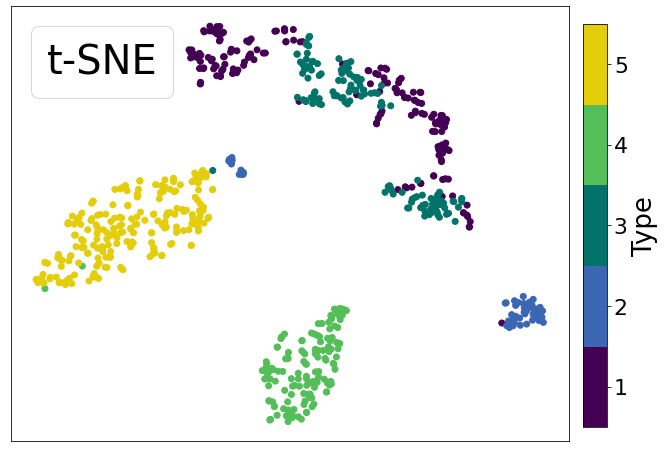

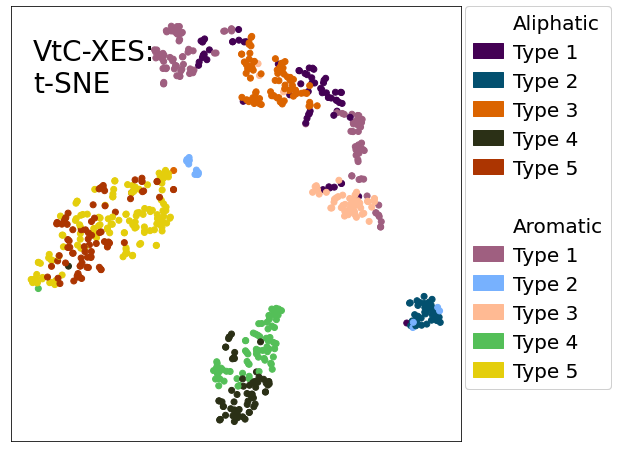

In [56]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE', black=True)
    plot_dim_red('oxy', X_TSNE, Labels[0],'t-SNE')
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE')
    plot_dim_red('category', X_TSNE, Labels[2],'t-SNE', xloc=0.05)

In [57]:
warnings.filterwarnings("ignore")

fastICA = FastICA(n_components=2)

fa = FactorAnalysis(n_components=2)

nmf = NMF(n_components=2)

pca = PCA(n_components=2)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XES)[0]

tsne = TSNE(n_components=2, perplexity=18, random_state=30)
everything = list(X)
for x in TEST_XES:
    everything.append(x)
everything = np.array(everything)
X_TSNE = tsne.fit_transform(everything)
TEST_SIZE = len(TEST_XES)

In [58]:
warnings.filterwarnings("ignore")
Acc = [[],[],[]]
print("Oxidation:")
neis = 20
i = 0
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis))
print("\nType:")
neis = 20
i = 1
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis))
print("\nAro:")
neis = 10
i = 2
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', X, TEST_XES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis))

Oxidation:
KNN on VAE: Oxidation (Accuracy: 1.00)
KNN on PCA: Oxidation (Accuracy: 0.85)
KNN on FastICA: Oxidation (Accuracy: 0.85)
KNN on FA: Oxidation (Accuracy: 1.00)
KNN on NMF: Oxidation (Accuracy: 0.88)
KNN on t-SNE: Oxidation (Accuracy: 1.00)

Type:
KNN on VAE: Type (Accuracy: 0.85)
KNN on PCA: Type (Accuracy: 0.69)
KNN on FastICA: Type (Accuracy: 0.69)
KNN on FA: Type (Accuracy: 0.85)
KNN on NMF: Type (Accuracy: 0.65)
KNN on t-SNE: Type (Accuracy: 0.88)

Aro:
KNN on VAE: Aromaticity (Accuracy: 0.69)
KNN on PCA: Aromaticity (Accuracy: 0.60)
KNN on FastICA: Aromaticity (Accuracy: 0.60)
KNN on FA: Aromaticity (Accuracy: 0.75)
KNN on NMF: Aromaticity (Accuracy: 0.50)
KNN on t-SNE: Aromaticity (Accuracy: 0.77)


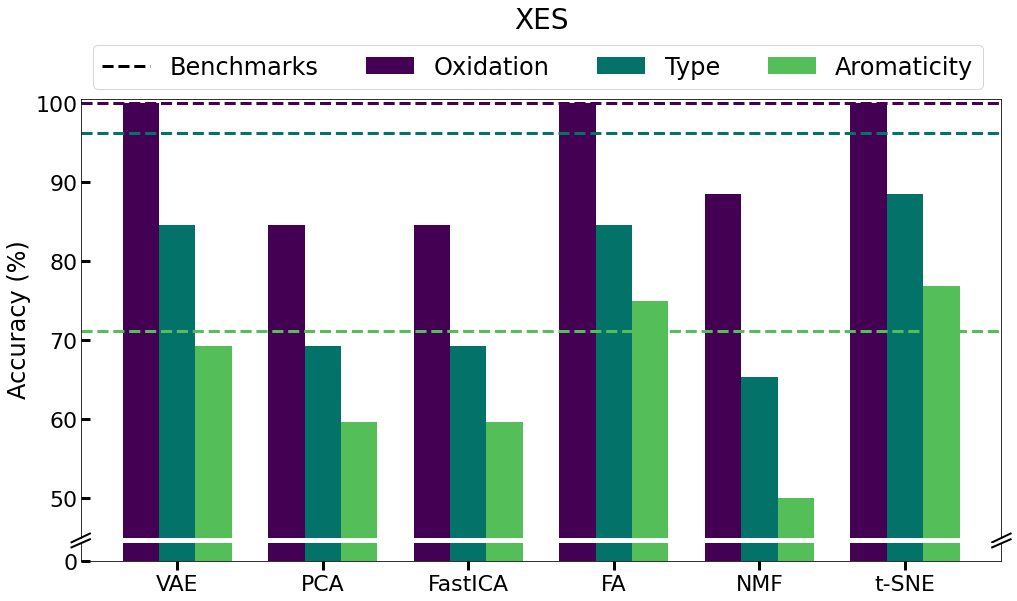

In [59]:
bar_chart(Acc, [100,96.2,71.2], mode='XES')

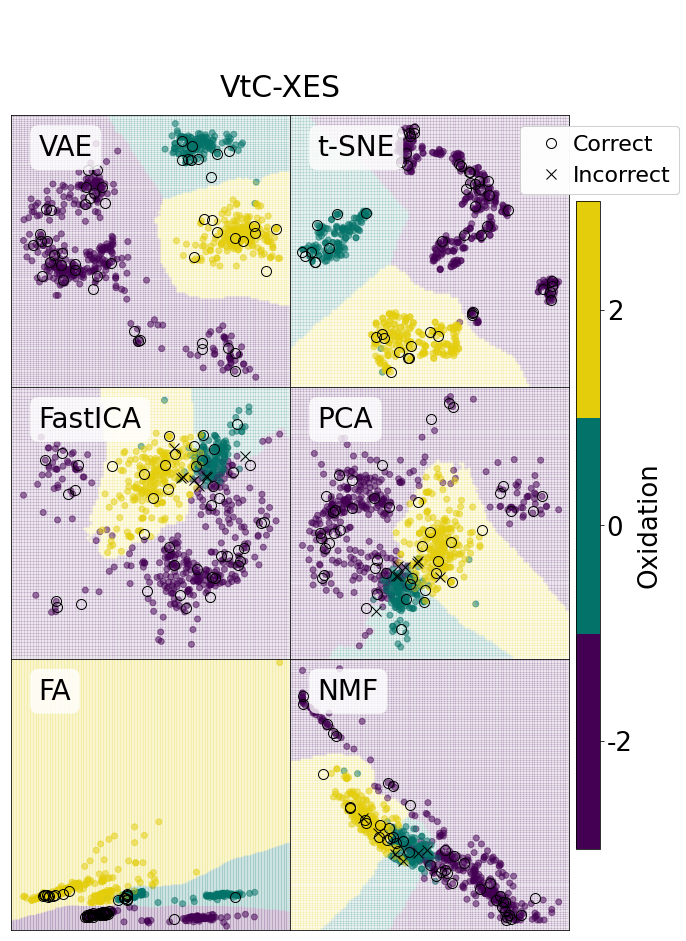

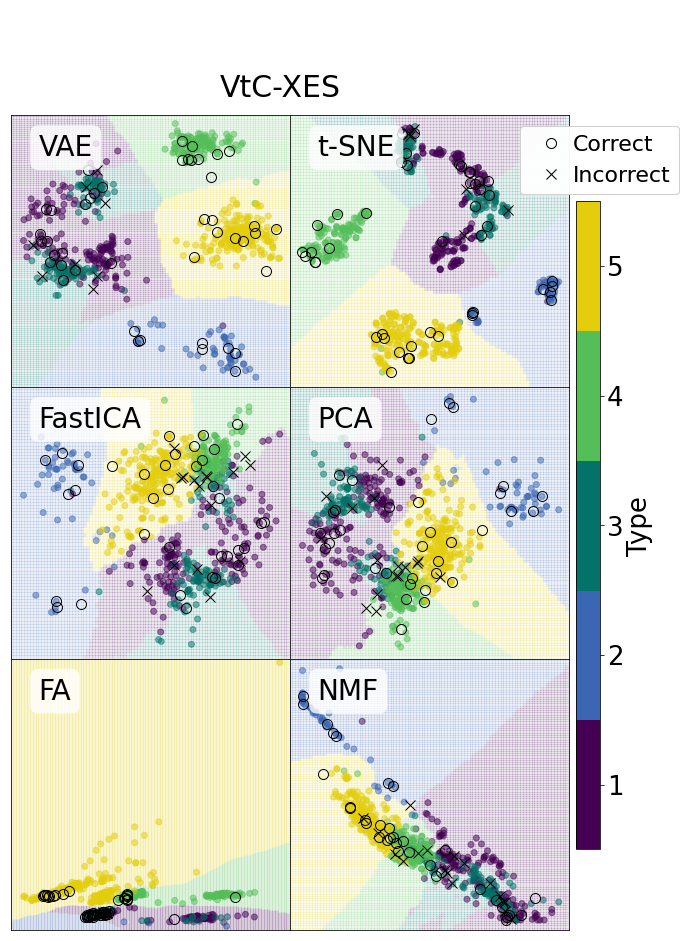

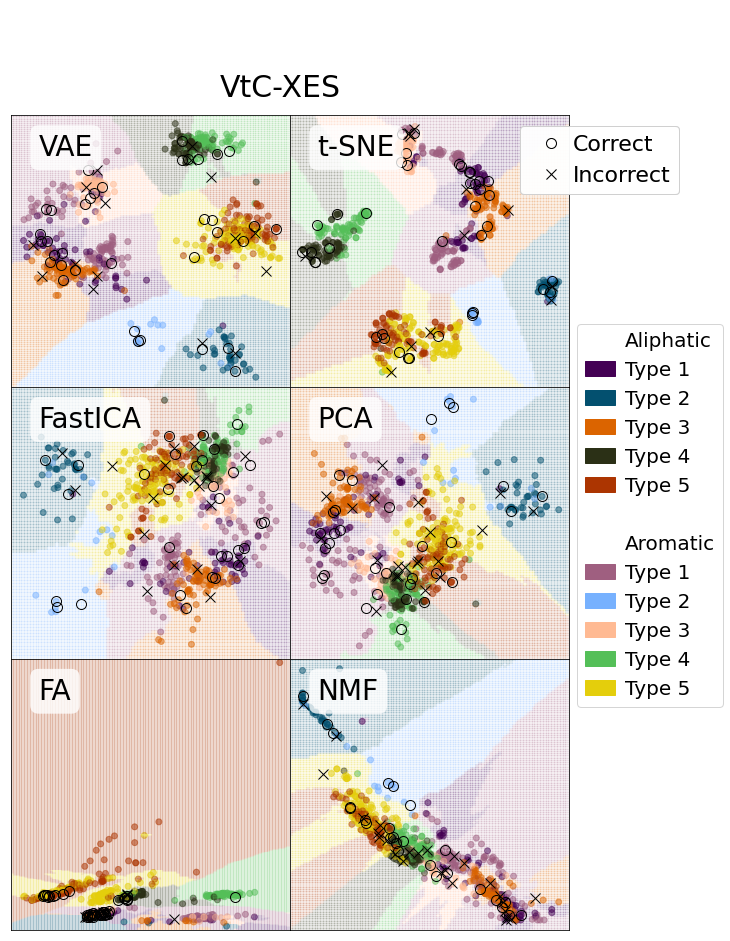

In [60]:
warnings.filterwarnings("ignore")
plot_KNN_stack('oxy', [z_mean, X_TSNE[:-TEST_SIZE,:], X_FastICA, X_PCA, X_FA, X_NMF],
               [TEST_z_mean, X_TSNE[-TEST_SIZE:,:], TEST_X_FastICA, TEST_X_PCA, TEST_X_FA, TEST_X_NMF],
               Labels[0], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], n_neighbors=20)

plot_KNN_stack('Type', [z_mean, X_TSNE[:-TEST_SIZE,:], X_FastICA, X_PCA, X_FA, X_NMF],
               [TEST_z_mean, X_TSNE[-TEST_SIZE:,:], TEST_X_FastICA, TEST_X_PCA, TEST_X_FA, TEST_X_NMF],
               Labels[1], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], n_neighbors=20)

plot_KNN_stack('category', [z_mean, X_TSNE[:-TEST_SIZE,:], X_FastICA, X_PCA, X_FA, X_NMF],
               [TEST_z_mean, X_TSNE[-TEST_SIZE:,:], TEST_X_FastICA, TEST_X_PCA, TEST_X_FA, TEST_X_NMF],
               Labels[2], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], n_neighbors=10)